In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

# GPU check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

(train_images, train_labels),(_,_) = tf.keras.datasets.cifar10.load_data() # (-,-)) we don't need test data.

Num GPUs Available:  1


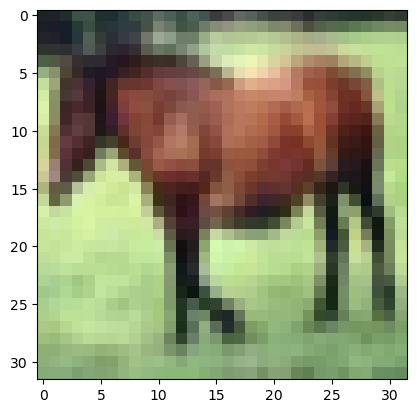

In [ ]:
plt.imshow(train_images[7])
plt.axis('off')
plt.show()

In [2]:
train_images

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [111]:

train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32') 
train_images = (train_images - 127.5)/127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 64
#batch_size will be the number of images we will feed into the model at once.
#buffer size is the number of images we will shuffle at once.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [112]:
train_images

array([[[[-0.5372549 , -0.5137255 , -0.5058824 ],
         [-0.6627451 , -0.6392157 , -0.64705884],
         [-0.60784316, -0.62352943, -0.6627451 ],
         ...,
         [ 0.23921569,  0.03529412, -0.15294118],
         [ 0.19215687, -0.01960784, -0.2       ],
         [ 0.16078432, -0.02745098, -0.19215687]],

        [[-0.8745098 , -0.84313726, -0.84313726],
         [-1.        , -1.        , -1.        ],
         [-0.85882354, -0.9372549 , -1.        ],
         ...,
         [-0.03529412, -0.30980393, -0.5686275 ],
         [-0.06666667, -0.34901962, -0.60784316],
         [-0.04313726, -0.31764707, -0.5529412 ]],

        [[-0.8039216 , -0.8117647 , -0.8352941 ],
         [-0.8745098 , -0.94509804, -1.        ],
         [-0.6156863 , -0.7882353 , -0.9372549 ],
         ...,
         [-0.07450981, -0.34117648, -0.60784316],
         [-0.05882353, -0.34117648, -0.60784316],
         [-0.14509805, -0.42745098, -0.67058825]],

        ...,

        [[ 0.6313726 ,  0.33333334, -0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


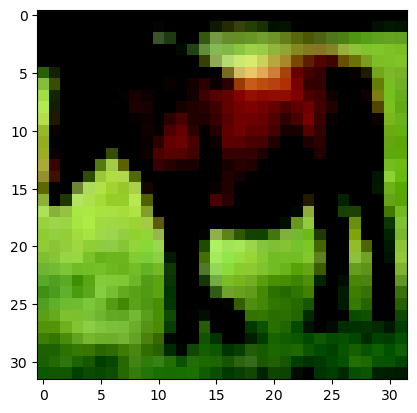

In [113]:
plt.imshow(train_images[7])
plt.axis('off')
plt.show()

The generator will produce an image from random noise. Starting with a dense layer that takes the random noise as input (the seed), then upsample several time until we reach the desired image size of 32x32x3. 
Particular guidelines of DCGANs

1) Replacing any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
2) Using batchnorm in both the generator and the discriminator.
3) Removing fully connected hidden layers for deeper architectures.
4) Using ReLU activation in generator for all layers except for the output, which uses tanh as the normalization is between [-1,1] rather than [0,1]
5) Using LeakyReLU activation in the discriminator for all layers.



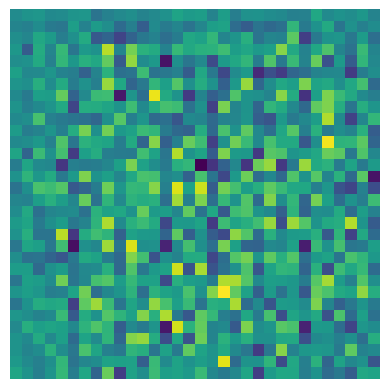

(1, 32, 32, 3)


In [4]:
kernel_size = 5
noise_dim = 100 #aka latent dim #aka codings size
#default alpha is 0.3 so im gonna tone it down a bit
alpha = 0.2

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(noise_dim,))) #8*8*256 = 16384 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = alpha))
    model.add(layers.Reshape((8, 8, 512))) 
    assert model.output_shape == (None, 8, 8, 512)  

    model.add(layers.Conv2DTranspose(256, kernel_size = kernel_size, strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = alpha))

    model.add(layers.Conv2DTranspose(128, kernel_size = kernel_size, strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = alpha))

    model.add(layers.Conv2DTranspose(3, kernel_size = kernel_size, strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model
colors = ["#FF0000", "#00FF00", "#0000FF"] #red,green,navy
cmap = matplotlib.colors.ListedColormap(colors)
#use generator (untrained)) to create an image & make sure it works
generator = make_generator_model()
noise = tf.random.normal([1,noise_dim])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])
plt.axis('off')
plt.show()
print(generated_image.shape)

## Discriminator 

In [5]:
kernel_size = (5)
#im gonna try an aggressive 0.4 dropoout and added a dense layer
#maybe depth of 512 is too much?
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size = kernel_size, strides=(2, 2), padding='same', input_shape=[32, 32, 3])) 
    model.add(tf.keras.layers.LeakyReLU(alpha= alpha))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Conv2D(128, kernel_size = kernel_size, strides=(2, 2), padding='same')) 
    model.add(tf.keras.layers.LeakyReLU(alpha= alpha)) 
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Conv2D(256, kernel_size = kernel_size, strides=(2, 2), padding='same')) 
    model.add(tf.keras.layers.LeakyReLU(alpha= alpha)) 
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Conv2D(512, kernel_size = kernel_size, strides=(1, 1), padding='same')) 
    model.add(tf.keras.layers.LeakyReLU(alpha= alpha)) 
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(1))

    return model

In [6]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00018512]], shape=(1, 1), dtype=float32)


## Loss, Optimizers & Checkpoints

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [8]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,generator=generator,discriminator=discriminator)

## Training Loop

The training loop will begin with the *generator* receiving a random seed as input. That seed is used to produce an image.
The *discriminator* is then used to classify *real images*(from the training set) and *fakes* (from the generator).  
The _loss_ is calculated for each and the gradients are used to update the generator and discriminator.

In [9]:
EPOCHS = 100 
num_examples_to_generate = 12 
seed = tf.random.normal([num_examples_to_generate, noise_dim]) 

In [10]:
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) # generate noise
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # use gradient tape to record gradients
        generated_images = generator(noise, training=True) # generate fake images

        real_output = discriminator(images, training=True) # train discriminator on real images
        fake_output = discriminator(generated_images, training=True) # train discriminator on fake images

        gen_loss = generator_loss(fake_output) # calculate generator loss
        disc_loss = discriminator_loss(real_output, fake_output) # calculate discriminator loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) 

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  

In [11]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure()

  for i in range(predictions.shape[0]):
      plt.subplot(3, 4, i+1)
      plt.imshow(predictions[i, :, :,0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [12]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

## Training


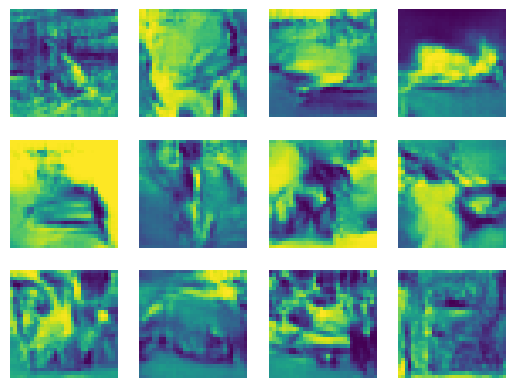

In [141]:
train(train_dataset, EPOCHS)

In [13]:
generator.predict(noise)

1/1 [==============================] - 0s 288ms/step


array([[[[-1.2864019e-03,  1.1535458e-04,  1.5602992e-03],
         [ 5.4675643e-04,  8.8958710e-05, -5.6980073e-04],
         [ 1.1657557e-03,  8.1123295e-04, -1.2593884e-03],
         ...,
         [-8.8116608e-04,  6.8395876e-04, -3.1949959e-03],
         [ 1.4226898e-03,  8.3024014e-04,  3.0840700e-04],
         [-3.4143806e-03,  4.7376049e-03,  1.0315008e-03]],

        [[-3.3196304e-03, -3.6138447e-03,  1.3263226e-03],
         [-4.1491264e-03, -7.0812055e-03, -5.1654424e-03],
         [-1.1056073e-03, -9.6203554e-03,  5.3926972e-03],
         ...,
         [ 9.7860349e-05, -1.1752741e-02, -3.9473064e-03],
         [-4.0428289e-03, -4.1612573e-03,  9.4835367e-03],
         [-1.0280103e-03,  8.8743551e-04, -7.4499855e-03]],

        [[-6.5649045e-04, -5.6505669e-03,  2.7399517e-03],
         [-2.7697477e-03, -4.8340573e-03,  4.5059477e-03],
         [ 5.5621527e-03, -1.2275461e-03,  1.2493057e-03],
         ...,
         [-6.3194260e-03, -4.1743866e-03, -5.2496966e-04],
         [

In [14]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Gif image

In [15]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [16]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.v2.imread(filename)
    writer.append_data(image)
  image = imageio.v2.imread(filename)
  writer.append_data(image)

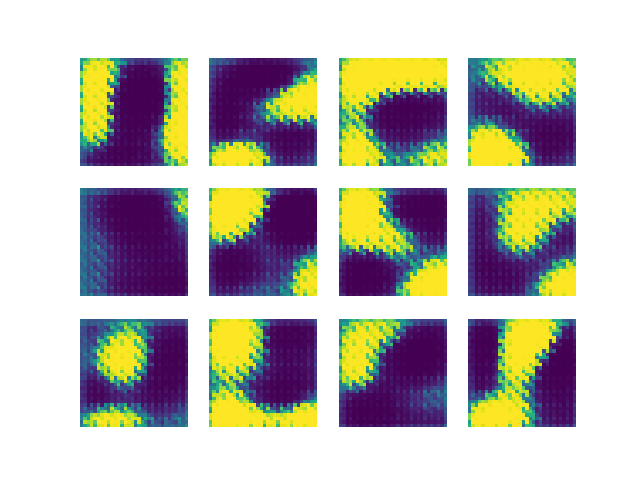

In [17]:
from IPython.display import Image
Image(filename=anim_file)